In [8]:
# Algorithm 1 - SIC Decoding Procedure
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [10]:
def Q_function(x):
    """Q-function: Q(x) = 1/sqrt(2π) * ∫_x^∞ exp(-t²/2)dt"""
    return 0.5 * (1 - norm.cdf(x))

def shannon_capacity(gamma):
    """Shannon capacity: C(γ) = log₂(1 + γ)"""
    return np.log2(1 + gamma)

def channel_dispersion(gamma):
    """Channel dispersion: V(γ) = γ²*(γ+2)/2*(γ+1)² * (log₂(e))²"""
    log2e_squared = (np.log(2))**(-2)
    return (gamma*(gamma+2)/((gamma + 1)**2 * 2)) * log2e_squared

def compute_error_probability(gamma, n, L):
    """
    Compute error probability using eq. (8):
    ϵₖ(t) = Q(√(n/V(γₖ(t))) · (C(γₖ(t)) - L/n))
    
    Args:
        gamma (float): SINR value
        n (int): Block length (number of complex channel uses)
        L (int): Packet size in bits
        
    Returns:
        float: Error probability
    """
    V = channel_dispersion(gamma)
    C = shannon_capacity(gamma)
    
    # Handle edge cases
    if gamma <= 0:
        return 1.0
    
    if C <= L/n:  # Cannot achieve required rate
        return 1.0
    
    argument = np.sqrt(n/V) * (C - L/n)
    return Q_function(argument)

def compute_SINR_with_SIC(k, active_users, received_powers, interference_matrix, decoded_status, noise_power):
    """
    Compute SINR for device k with SIC according to eq. (6)
    
    Args:
        k (int): Device index
        active_users (list): List of active user indices
        received_powers (np.array): Vector of received powers (η)
        interference_matrix (np.array): Matrix of interference coefficients (ηⱼₖ)
        decoded_status (np.array): Vector indicating if a device has been successfully decoded (φ)
        noise_power (float): Noise power (σ²)
        
    Returns:
        float: SINR value
    """
    # Find k's position in the decoding order
    k_order = np.where(np.argsort(-received_powers[active_users]) == active_users.index(k))[0][0]
    
    # Interference from devices before k in decoding order that were not successfully decoded
    before_k = [active_users[j] for j in range(k_order) if not decoded_status[active_users[j]]]
    
    # Interference from devices after k in decoding order
    after_k = [active_users[j] for j in range(k_order+1, len(active_users))]
    
    # Calculate interference
    interference = 0
    for j in before_k:
        interference += interference_matrix[j, k]
    
    for j in after_k:
        interference += interference_matrix[j, k]
    
    # Calculate SINR
    sinr = received_powers[k] / (interference + noise_power)
    return sinr


In [11]:
def SIC_decoding_procedure(active_users, received_powers, interference_matrix, B, n, L, noise_power):
    """
    SIC Decoding Procedure (Algorithm 1)
    
    Args:
        active_users (list): Set of active users U(t)
        received_powers (np.array): Vector of received powers η(t)
        interference_matrix (np.array): Matrix of interference coefficients ηⱼₖ(t)
        B (int): SIC limitation
        n (int): Block length
        L (int): Packet size in bits
        noise_power (float): Noise power (σ²)
        
    Returns:
        np.array: Vector of successful decoding indicators φ(t)
    """
    K = len(received_powers)  # Total number of devices
    phi = np.zeros(K, dtype=int)  # Initialize φₖ(t) = 0, ∀k
    
    # Check if number of active users exceeds SIC limitation
    if len(active_users) <= B:
        # Sort active users in decreasing order of received power
        sorted_indices = np.argsort(-received_powers[active_users])
        sorted_active_users = [active_users[i] for i in sorted_indices]
        
        # Process each active user in decreasing order of received power
        for k in sorted_active_users:
            # Compute SINR with SIC
            gamma_k = compute_SINR_with_SIC(k, sorted_active_users, received_powers, interference_matrix, phi, noise_power)
            
            # Compute error probability
            epsilon_k = compute_error_probability(gamma_k, n, L)
            
            # Draw φₖ(t) from Bernoulli distribution B(1-ϵₖ(t))
            phi[k] = np.random.binomial(1, 1-epsilon_k)
            
    return phi



In [12]:
# Example usage with real-world scenario
def demonstrate_SIC_decoding():
    # Parameters
    K = 5  # Number of devices
    B = 3  # SIC limitation
    n = 200  # Block length
    L = 256  # Packet size in bits (32 bytes)
    noise_power = 1e-9  # Noise power
    
    # Create random received powers (in decreasing order from device 0 to K-1 for simplicity)
    received_powers = np.array([1e-6, 8e-7, 5e-7, 3e-7, 1e-7])
    
    # Create random interference matrix
    # In a real implementation, this would be calculated based on channel coefficients
    interference_matrix = np.zeros((K, K))
    for j in range(K):
        for k in range(K):
            if j != k:
                interference_matrix[j, k] = received_powers[j] * np.random.uniform(0.05, 0.2)
    
    # Simulate different active user scenarios
    scenarios = [
        [0, 1],  # Two users with strongest signals
        [0, 1, 2],  # Three users with strongest signals (at SIC limit)
        [0, 1, 2, 3],  # Four users (exceeds SIC limit)
        [2, 3, 4]  # Three users with weaker signals
    ]
    
    results = []
    for scenario_idx, active_users in enumerate(scenarios):
        print(f"\nScenario {scenario_idx+1}: Active users {active_users}")
        
        # Run SIC decoding procedure
        phi = SIC_decoding_procedure(active_users, received_powers, interference_matrix, B, n, L, noise_power)
        
        # Display results
        print("Received powers:", {k: f"{received_powers[k]:.2e}" for k in active_users})
        print("Decoding results:", {k: ("Success" if phi[k] else "Failure") for k in active_users})
        
        # Calculate SINR and error probability for each active user
        for k in active_users:
            sorted_active = sorted(active_users, key=lambda x: -received_powers[x])
            gamma_k = compute_SINR_with_SIC(k, sorted_active, received_powers, interference_matrix, np.zeros(K), noise_power)
            epsilon_k = compute_error_probability(gamma_k, n, L)
            print(f"Device {k}: SINR = {gamma_k:.2f}, Error probability = {epsilon_k:.4f}")
        
        results.append((active_users, phi))
    
    # Plot results
    fig, ax = plt.subplots(figsize=(10, 6))
    
    bar_width = 0.2
    x = np.arange(len(scenarios))
    
    # Calculate success rates for each scenario
    success_rates = [sum(phi[active])/len(active) for active, phi in results]
    
    ax.bar(x, success_rates, bar_width, label='Success Rate')
    
    # Number of active users in each scenario
    active_counts = [len(active) for active, _ in results]
    ax.plot(x, [count/B for count in active_counts], 'r--', label='Load/Capacity Ratio')
    
    ax.set_xticks(x)
    ax.set_xticklabels([f'Scenario {i+1}' for i in range(len(scenarios))])
    ax.set_ylim(0, 1.2)
    ax.set_ylabel('Rate')
    ax.set_title('SIC Decoding Performance')
    ax.legend()
    
    plt.tight_layout()
    plt.savefig('sic_decoding_performance.png')
    plt.show()
    
    return results



Scenario 1: Active users [0, 1]
Received powers: {0: '1.00e-06', 1: '8.00e-07'}
Decoding results: {0: 'Success', 1: 'Success'}
Device 0: SINR = 16.74, Error probability = 0.0000
Device 1: SINR = 7.46, Error probability = 0.0000

Scenario 2: Active users [0, 1, 2]
Received powers: {0: '1.00e-06', 1: '8.00e-07', 2: '5.00e-07'}
Decoding results: {0: 'Success', 1: 'Success', 2: 'Success'}
Device 0: SINR = 7.70, Error probability = 0.0000
Device 1: SINR = 4.32, Error probability = 0.0000
Device 2: SINR = 1.98, Error probability = 0.0000

Scenario 3: Active users [0, 1, 2, 3]
Received powers: {0: '1.00e-06', 1: '8.00e-07', 2: '5.00e-07', 3: '3.00e-07'}
Decoding results: {0: 'Failure', 1: 'Failure', 2: 'Failure', 3: 'Failure'}
Device 0: SINR = 5.49, Error probability = 0.0000
Device 1: SINR = 3.81, Error probability = 0.0000
Device 2: SINR = 1.81, Error probability = 0.0004
Device 3: SINR = 1.28, Error probability = 1.0000

Scenario 4: Active users [2, 3, 4]
Received powers: {2: '5.00e-07', 

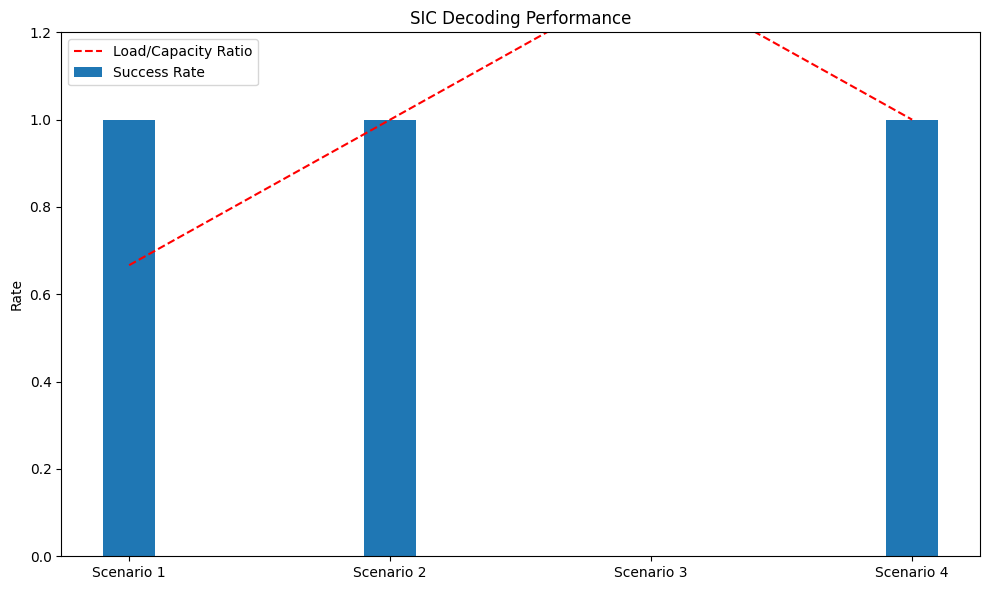

In [13]:
# Run the demonstration
if __name__ == "__main__":
    np.random.seed(42)  # For reproducibility
    results = demonstrate_SIC_decoding()

In [14]:
#algorithm 2 
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical, Bernoulli
import matplotlib.pyplot as plt
from collections import deque, namedtuple
import time
import os

In [ ]:
# Set seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [ ]:
# Helper functions for error probability calculation
def Q_function(x):
    """Q-function: Q(x) = 1/sqrt(2π) * ∫_x^∞ exp(-t²/2)dt"""
    return 0.5 * (1 - norm.cdf(x))

def shannon_capacity(gamma):
    """Shannon capacity: C(γ) = log₂(1 + γ)"""
    return np.log2(1 + gamma)

def channel_dispersion(gamma):
    """Channel dispersion: V(γ) = γ²*(γ+2)/2*(γ+1)² * (log₂(e))²"""
    log2e_squared = (np.log(2))**(-2)
    return (gamma*(gamma+2)/((gamma + 1)**2 * 2)) * log2e_squared

def compute_error_probability(gamma, n, L):
    """Compute error probability using finite block length regime"""
    V = channel_dispersion(gamma)
    C = shannon_capacity(gamma)
    
    # Handle edge cases
    if gamma <= 0 or C <= L/n:
        return 1.0
    
    argument = np.sqrt(n/V) * (C - L/n)
    return Q_function(argument)



In [ ]:
# Define the wireless environment
class WirelessEnvironment:
    def __init__(self, 
                 num_devices=10,
                 num_antennas=4,
                 sic_limit=3,
                 block_length=200,
                 packet_size=256,  # bits
                 noise_power=1e-9,
                 traffic_type='deterministic_periodic',
                 traffic_period=10,
                 traffic_probability=1.0,
                 poisson_rate=0.1,
                 deadline=5,
                 area_side=500,  # m
                 max_episode_length=200):
        
        # Network parameters
        self.K = num_devices
        self.na = num_antennas
        self.B = sic_limit
        self.n = block_length
        self.L = packet_size
        self.noise_power = noise_power
        
        # Traffic parameters
        self.traffic_type = traffic_type
        self.Np = traffic_period
        self.xi = traffic_probability
        self.lambda_poisson = poisson_rate
        self.delta = deadline
        
        # Environment dimensions
        self.area_side = area_side
        self.max_episode_length = max_episode_length
        
        # Statistics tracking
        self.total_packets_generated = 0
        self.packets_delivered = 0
        
        # Initialize device positions
        self.initialize_devices()
        
        # Initialize time tracking vectors
        self.tau_p = np.ones(self.K) * np.inf  # Time since last poll
        self.tau_a = np.ones(self.K) * np.inf  # Time since last active
        self.tau_s = np.ones(self.K) * np.inf  # Time since last successful decode
        
        # Buffer initialization
        self.reset()
        
    def initialize_devices(self):
        # Random positions in area
        x = np.random.uniform(-self.area_side/2, self.area_side/2, self.K)
        y = np.random.uniform(-self.area_side/2, self.area_side/2, self.K)
        
        # Calculate distances to BS
        self.distances = np.sqrt(x**2 + y**2)
        
        # Initialize channel parameters - large scale fading based on distance
        self.g = 1 / (1 + self.distances**3)  # Simple path loss model
        
        # Initialize fast fading channels (will evolve over time)
        self.H = np.random.randn(self.na, self.K) + 1j * np.random.randn(self.na, self.K)
        self.H = self.H / np.sqrt(2)  # Normalize for complex channels
        
        # Initialize received powers
        self.update_received_powers()
        
        # Generate offsets for periodic traffic
        self.offsets = np.random.randint(0, self.Np, size=self.K)
        
    def update_received_powers(self):
        # Compute received power for each device based on channel conditions
        self.eta = np.zeros(self.K)
        for k in range(self.K):
            h_k = self.H[:, k]
            self.eta[k] = self.g[k] * np.sum(np.abs(h_k)**2)
    
    def evolve_channels(self):
        # Time evolution of fast fading using Gauss-Markov model
        # Assuming correlation coefficient of 0.9 for simplicity
        rho = 0.9
        for k in range(self.K):
            self.H[:, k] = rho * self.H[:, k] + np.sqrt(1-rho**2) * (np.random.randn(self.na) + 1j * np.random.randn(self.na)) / np.sqrt(2)
        
        # Update received powers based on new channel state
        self.update_received_powers()
    
    def generate_traffic(self, t):
        # Generate new packets according to traffic model
        new_packets = np.zeros(self.K, dtype=int)
        
        if self.traffic_type == 'deterministic_periodic':
            for k in range(self.K):
                if t % self.Np == self.offsets[k]:
                    new_packets[k] = 1
                    self.total_packets_generated += 1
        
        elif self.traffic_type == 'probabilistic_periodic':
            for k in range(self.K):
                if t % self.Np == self.offsets[k] and np.random.random() < self.xi:
                    new_packets[k] = 1
                    self.total_packets_generated += 1
        
        elif self.traffic_type == 'probabilistic_aperiodic':
            for k in range(self.K):
                # Poisson process
                if np.random.random() < self.lambda_poisson:
                    new_packets[k] = 1
                    self.total_packets_generated += 1
        
        return new_packets
    
    def reset(self):
        # Reset buffer state
        self.buffer = np.zeros((self.K, self.delta), dtype=int)
        
        # Reset time tracking
        self.tau_p = np.ones(self.K) * np.inf
        self.tau_a = np.ones(self.K) * np.inf
        self.tau_s = np.ones(self.K) * np.inf
        
        # Reset statistics for this episode
        self.packets_delivered = 0
        self.total_packets_generated = 0
        
        # Initialize channels
        self.initialize_devices()
        
        # Reset time and generate initial packets
        self.t = 0
        new_packets = self.generate_traffic(self.t)
        for k in range(self.K):
            if new_packets[k] > 0:
                self.buffer[k, self.delta-1] = new_packets[k]
        
        # Generate observation
        obs = self.get_observation()
        
        return obs
    
    def get_head_of_line_delays(self):
        # Find the head-of-line delays for each device
        d_h = np.ones(self.K) * np.inf
        for k in range(self.K):
            for d in range(self.delta):
                if self.buffer[k, d] > 0:
                    d_h[k] = d + 1  # Add 1 because index 0 is delay 1
                    break
        return d_h
    
    def get_observation(self):
        # Return the current observation for the agent
        # This includes buffer observations, channel observations, and timing information
        
        # Buffer observation - head of line delays
        d_h = self.get_head_of_line_delays()
        
        # Normalize head of line delays to [0, 1]
        buffer_obs = np.where(d_h < np.inf, d_h / self.delta, 0)
        
        # Channel observation - only for active users
        u = np.zeros(self.K, dtype=int)
        for k in range(self.K):
            if np.any(self.buffer[k] > 0):
                u[k] = 1
        
        eta_obs = self.eta * u
        
        # Timing information
        tau_p_norm = 1.0 / np.where(self.tau_p > 0, self.tau_p, np.inf)
        tau_a_norm = 1.0 / np.where(self.tau_a > 0, self.tau_a, np.inf)
        tau_s_norm = 1.0 / np.where(self.tau_s > 0, self.tau_s, np.inf)
        
        # Replace inf with 0
        tau_p_norm = np.nan_to_num(tau_p_norm)
        tau_a_norm = np.nan_to_num(tau_a_norm)
        tau_s_norm = np.nan_to_num(tau_s_norm)
        
        # Create final state vector
        obs = np.concatenate([
            buffer_obs,
            tau_p_norm,
            tau_a_norm,
            tau_s_norm,
            eta_obs
        ])
        
        return obs
    

In [ ]:
def SIC_decoding_procedure(self, active_users):
        """
        SIC Decoding Procedure (Algorithm 1)
        """
        phi = np.zeros(self.K, dtype=int)  # Initialize φₖ(t) = 0, ∀k
        
        # Check if number of active users exceeds SIC limitation
        if len(active_users) <= self.B:
            # Create interference matrix between devices
            interference_matrix = np.zeros((self.K, self.K))
            for j in range(self.K):
                for k in range(self.K):
                    if j != k:
                        # Simple interference model: proportional to power and similarity of channels
                        h_j = self.H[:, j]
                        h_k = self.H[:, k]
                        channel_correlation = np.abs(np.vdot(h_j, h_k))**2 / (np.sum(np.abs(h_j)**2) * np.sum(np.abs(h_k)**2))
                        interference_matrix[j, k] = self.eta[j] * channel_correlation * 0.1
            
            # Sort active users in decreasing order of received power
            sorted_indices = np.argsort(-self.eta[active_users])
            sorted_active_users = [active_users[i] for i in sorted_indices]
            
            # Process each active user in decreasing order of received power
            for k in sorted_active_users:
                # Compute SINR with SIC
                gamma_k = self.compute_SINR_with_SIC(k, sorted_active_users, interference_matrix, phi)
                
                # Compute error probability
                epsilon_k = compute_error_probability(gamma_k, self.n, self.L)
                
                # Draw φₖ(t) from Bernoulli distribution B(1-ϵₖ(t))
                phi[k] = np.random.binomial(1, 1-epsilon_k)
                
        return phi
    

In [ ]:
def compute_SINR_with_SIC(self, k, sorted_active_users, interference_matrix, phi):
        """
        Compute SINR for device k with SIC
        """
        # Find k's position in the decoding order
        k_order = sorted_active_users.index(k)
        
        # Interference from devices before k in decoding order that were not successfully decoded
        before_k = [j for j in sorted_active_users[:k_order] if not phi[j]]
        
        # Interference from devices after k in decoding order
        after_k = sorted_active_users[k_order+1:]
        
        # Calculate interference
        interference = 0
        for j in before_k:
            interference += interference_matrix[j, k]
        
        for j in after_k:
            interference += interference_matrix[j, k]
        
        # Calculate SINR
        sinr = self.eta[k] / (interference + self.noise_power)
        return sinr

In [ ]:
# Define the policy and value networks with branching architecture
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=256):
        super(PolicyNetwork, self).__init__()
        
        # Shared layers
        self.shared_layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Individual branch for each device
        self.branches = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, 1),
                nn.Sigmoid()
            ) for _ in range(output_dim)
        ])
    
    def forward(self, x):
        # Process through shared layers
        shared_features = self.shared_layers(x)
        
        # Process through individual branches
        branch